In [1]:
# from tqdm import tqdm
import pandas as pd
import numpy as np
from random import shuffle
import pickle

In [2]:
import torch
from torch import optim
from torch.autograd import Variable,gradcheck
from torch.utils.data import DataLoader

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
sing = pd.read_csv('wooddata/singleton.csv')
pair = pd.read_csv('wooddata/pair.csv')
trip = pd.read_csv('wooddata/triplet.csv')

## Inspection

In [4]:
with open('embeddings', 'rb') as handle:
    edge_vals = pickle.load(handle)

x_sing = sing[['[Sal]', '[Ery]', '[Cm]', '[Tmp]', '[Ofl]', '[Dox]', '[Linc]']].values
x_pair = pair[['[Sal]', '[Ery]', '[Cm]', '[Tmp]', '[Ofl]', '[Dox]', '[Linc]']].values
x_trip = trip[['[Sal]', '[Ery]', '[Cm]', '[Tmp]', '[Ofl]', '[Dox]', '[Linc]']].values
x_edge = np.array(list(edge_vals.values()))

x_sing = np.concatenate((x_sing, x_edge * np.ones((x_sing.shape[0], 1))), axis=1)
x_pair = np.concatenate((x_pair, x_edge * np.ones((x_pair.shape[0], 1))), axis=1)
x_trip = np.concatenate((x_trip, x_edge * np.ones((x_trip.shape[0], 1))), axis=1)

x = np.concatenate((x_sing, x_pair, x_trip), axis=0)

y_sing = sing['g'].values
y_pair = pair['g'].values
y_trip = trip['g'].values
y = np.concatenate((y_sing, y_pair, y_trip), axis=0)

In [5]:
with open('embeddings', 'rb') as handle:
    edge_vals = pickle.load(handle)

In [6]:
from DNN import DNN

# split dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50)

len(X_train), len(X_val), len(X_test)

(2336, 292, 292)

In [7]:
# normalize on training set and apply to test set
std_scaler_x = StandardScaler()
std_scaler_y = StandardScaler()

# fit and transform on training set
X_train = std_scaler_x.fit_transform(X_train)
y_train = std_scaler_y.fit_transform(
    y_train[:, np.newaxis]
).ravel()

# apply transformation on validation set
X_val = std_scaler_x.transform(X_val)
y_val = std_scaler_y.transform(
    y_val[:, np.newaxis]
).ravel()

# apply transformation on test set
X_test = std_scaler_x.transform(X_test)
y_test = std_scaler_y.transform(
    y_test[:, np.newaxis]
).ravel()

In [8]:
%%time
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# model settings
D_in  = X_train.shape[1]
D_out = 1
H = 50
Depth = 5
NUMEPOCHS = 500
Batch_size = 100

model = DNN(
    input_size=D_in,
    output_size=D_out,
    hidden_size=H,
    depth=Depth
).to(device)

# Loss Function
criterion = torch.nn.MSELoss()

# Optimizer
optimizer = optim.Adamax(model.parameters())

CPU times: user 2.49 s, sys: 895 ms, total: 3.39 s
Wall time: 3.39 s


In [9]:
# Input Data
trainX = Variable(torch.from_numpy(X_train).float())
trainY = Variable(torch.from_numpy(y_train).float())
testX = Variable(torch.from_numpy(X_test).float())
testY = Variable(torch.from_numpy(y_test).float())

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

# For Supervising Losses
losses = list()

if torch.cuda.is_available():
    trainX = trainX.to(device)
    trainY = trainY.to(device)
    testX = testX.to(device)
    testY = testY.to(device)
    
data_train_loader = DataLoader(
    list(zip(trainX,trainY)), 
    batch_size=Batch_size, 
    shuffle=True
)

torch.Size([2336, 56])
torch.Size([2336])
torch.Size([292, 56])
torch.Size([292])


In [10]:
# Train the model

print("Epochs")
for epoch in range(NUMEPOCHS):
    for batchX, batchY in data_train_loader: 
        # Forward pass
        outputs = model(batchX)
        loss = criterion(outputs.squeeze(), batchY)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()     
        optimizer.step()
        losses.append(loss)
        
    # Print Epochs and Losses to Monitor Convergence
    if epoch % 50 == 0:
        print("{}".format(epoch),end = ", ")
        print(loss)
        
print('\nTraining Complete')

Epochs
0, tensor(0.3288, device='cuda:0', grad_fn=<MseLossBackward>)
50, tensor(0.0550, device='cuda:0', grad_fn=<MseLossBackward>)
100, tensor(0.0730, device='cuda:0', grad_fn=<MseLossBackward>)
150, tensor(0.0860, device='cuda:0', grad_fn=<MseLossBackward>)
200, tensor(0.0850, device='cuda:0', grad_fn=<MseLossBackward>)
250, tensor(0.1124, device='cuda:0', grad_fn=<MseLossBackward>)
300, tensor(0.0557, device='cuda:0', grad_fn=<MseLossBackward>)
350, tensor(0.0874, device='cuda:0', grad_fn=<MseLossBackward>)
400, tensor(0.0591, device='cuda:0', grad_fn=<MseLossBackward>)
450, tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)

Training Complete


In [11]:
pred = model(testX)

In [12]:
predictions = pred.detach().cpu().numpy().ravel()
testvals = testY.cpu().numpy()

In [13]:
predictions = std_scaler_y.inverse_transform(predictions[:, np.newaxis]).ravel()
testvals = std_scaler_y.inverse_transform(testvals[:, np.newaxis]).ravel()
mse = np.mean((predictions - testvals) ** 2)
print('Test MSE = ', mse)

Test MSE =  0.0020532282


In [14]:
predictions.shape

(292,)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

y_all = pd.DataFrame({
    'pred': predictions,
    'true': testvals
})

y_all = y_all.sort_values(by=['true']).reset_index()[['pred', 'true']]

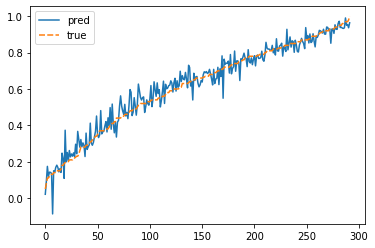

In [16]:
sns.lineplot(data=y_all)
plt.legend()
plt.show()

In [18]:
print('%f%%' % ((0.0024363457 - 0.0020532282) / 0.0024363457 * 100))

15.725088%
